In [1]:
#from functools import partial
import numpy as np

%matplotlib ipympl
import matplotlib.pyplot as plt
from matplotlib.widgets import RadioButtons, Slider

In [2]:
def swish(x):
    return x / (1+ np.exp(-x))

In [3]:
# global w_in, w_gate, x_mid, x_out, x_post
# global w_in_arr, w_gate_arr
w_out_arr = np.array([1,0])

In [29]:
def weights(ax, label):
    if "strengthening" in label:
        w_in_arr = np.array([0.98,0.04])
    elif "weakening" in label:
        w_in_arr = np.array([-0.98,0])
    else:
        w_in_arr = np.array([0.02,1.04])
    w_in = ax.arrow(0,0,*w_in_arr,
                    color='blue',
                    label='$w_{in}$',
                    length_includes_head=True,
                    head_width=0.1,
                 )
    
    if ("conditional" in label) or label=="orthogonal output":
        w_gate_arr = np.array([-0.02,0.96])
    elif label=="weakening":
        w_gate_arr = np.array([-0.98,-0.04])
    else:
        w_gate_arr = np.array([0.98,-0.04])
    w_gate = ax.arrow(0,0,*w_gate_arr,
                      color='red',
                      label='$w_{gate}$',
                      length_includes_head=True,
                      head_width=0.1,
                 )
    return ax, w_in_arr, w_gate_arr

In [30]:
def computation(ax, x, y, w_in_arr, w_gate_arr):
    x_mid = ax.arrow(0,0,x,y,
                     color='black',
                     label='$x_{mid}$ (residual stream before neuron)',
                     length_includes_head=True,
                     head_width=0.1,
                     )
    x_mid_arr = np.array([x,y])
    x_ln = x_mid_arr / np.linalg.norm(x_mid_arr)
    x_out_scalar = swish(np.dot(x_ln, w_gate_arr)) * np.dot(x_ln, w_in_arr)
    x_out_arr = x_out_scalar * w_out_arr
    x_out = ax.arrow(*x_mid_arr, *x_out_arr,
                     color='olive',
                     label='neuron output',
                     length_includes_head=True,
                     head_width=0.1,
                     )
    x_post_arr = x_mid_arr + x_out_arr
    x_post = ax.arrow(0,0,*x_post_arr,
                      color='gray',
                      label='$x_{post}$ (residual stream after neuron)',
                      length_includes_head=True,
                      head_width=0.1,
                      )
    return ax

In [31]:
def update_all(ax=None, label="strengthening", x=1, y=1, polar=False):
    for i,arrow in enumerate(ax.patches):
        if i>0:
            ax.patches.remove(arrow)
    ax, w_in_arr, w_gate_arr = weights(ax, label)
    if polar:
        phi=x
        r=y
        x = r * np.cos(phi)
        y = r * np.sin(phi)
    ax = computation(ax, x, y, w_in_arr, w_gate_arr)
    return ax, w_in_arr, w_gate_arr

# def update_computation(ax, x, y, w_in_arr, w_gate_arr):
#     for i,arrow in enumerate(ax.patches):
#         if i>3:
#             ax.patches.remove(arrow)
#     ax = computation(x, y, w_in_arr, w_gate_arr)
#     return ax

In [32]:
def interactive(polar=False):
    fig, axs = plt.subplots(3,2,
                            height_ratios=[1,0.03,0.03],
                            width_ratios=[2,1],
                            figsize=(12,8.48),
                            #sharex=True,
                            )
    # fig.set_figwidth(12)
    # fig.set_figheight(6)

    axs[1,1].axis('off')
    axs[2,1].axis('off')

    ax = axs[0,0]

    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_aspect('equal', adjustable='box', anchor='E')

    w_out = ax.arrow(0,0,1,0,
                    color='g',
                    label='$w_{out}$',
                    length_includes_head=True,
                    head_width=0.1,
                    )

    rax = axs[0,1]#fig.add_axes([0.6,0,0.3,0.3])
    radio = RadioButtons(rax, labels=
                        ["strengthening",
                        "conditional strengthening",
                        "weakening",
                        "conditional weakening",
                        "proportional change",
                        "orthogonal output",
                        ]
                        )

    first_label = "strengthening"
    x0 = 0.5
    y0 = 1

    xslideraxis = axs[1,0]#fig.add_axes([0.25, 0, 0.65, 0.03])
    yslideraxis = axs[2,0]#fig.add_axes([0.25, -0.1, 0.65, 0.03])

    if not polar:
        xslider = Slider(xslideraxis,
                        label='$x_{mid}$ (1st coord.)',
                        valmin=-2,
                        valmax=2,
                        valinit=x0,
                        )
        yslider = Slider(yslideraxis,
                        label='$x_{mid}$ (2nd coord.)',
                        valmin=-2,
                        valmax=2,
                        valinit=y0,
                        )
    else:
        r0 = np.sqrt(x0**2 + y0**2)
        phi0 = np.arccos(x0/r0) * np.sign(y0)
        xslider = Slider(xslideraxis,
                        label='$x_{mid}$ (angle in rad.)',
                        valmin=-np.pi,
                        valmax=np.pi,
                        valinit=phi0,
                        )
        yslider = Slider(yslideraxis,
                        label='$x_{mid}$ (radius)',
                        valmin=0.125,
                        valmax=2,
                        valinit=r0,
                        )

    ax, w_in_arr, w_gate_arr = weights(ax, first_label)
    ax = computation(ax, x0, y0, w_in_arr, w_gate_arr)


    radio.on_clicked(
        lambda label: update_all(
            ax=ax,
            label=label,
            x=xslider.val,
            y=yslider.val,
            polar=polar,
            )
            )
    xslider.on_changed(lambda x: update_all(
        ax=ax,
        label=radio.value_selected,
        x=x,
        y=yslider.val,
        polar=polar,
    ))
    yslider.on_changed(lambda y: update_all(
        ax=ax,
        label=radio.value_selected,
        x=xslider.val,
        y=y,
        polar=polar,
    ))

    ax.legend()

    return fig, axs, radio, xslider, yslider


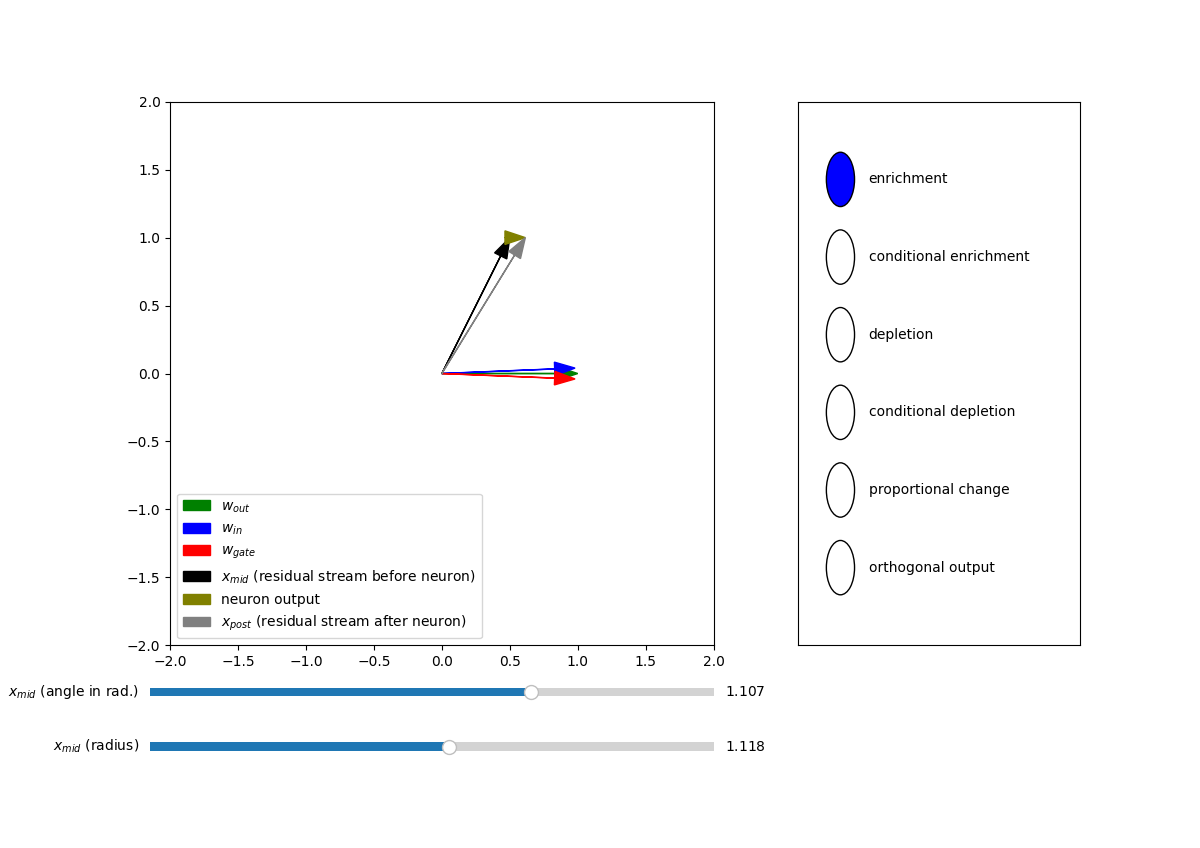

In [33]:
fig, axs, radio, xslider, yslider = interactive(polar=True)